In [1]:
#importing packages relevant to this project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
%matplotlib inline

## Camera Calibration

### 1. Loading the images

In [2]:
def load_images(names_path, names_list):
    images = []
    for name in names_list:
        images.append(cv2.imread(names_path + name))
    return images

In [3]:
# Path Containing Calibration images
calibration_path = 'camera_cal/'

# Grid Dimensions
nx = 9
ny = 6

# Generate a standard 9x6 grid
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

calibration_image_names = os.listdir(calibration_path)


calibration_images = load_images(calibration_path, 
                                 calibration_image_names)
objpoints = []
imgpoints = []
for i in range(len(calibration_images)):
    image = calibration_images[i]
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(image, (nx,ny),None)

    # If corners were found, add an instance of the objectpoints representing a grid
    # Add Detected Corners to ImagePoints
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw corners and show
        img = cv2.drawChessboardCorners(image, (nx,ny), corners,ret)

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[::-1],None,None)

In [40]:
img = np.copy(calibration_images[0])
# undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show undistorted and original images for verification
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.xlabel('Original')
plt.imshow(img, cmap='gray')
plt.subplot(222)
plt.imshow(dst, cmap = 'gray')
plt.xlabel('Undistorted')

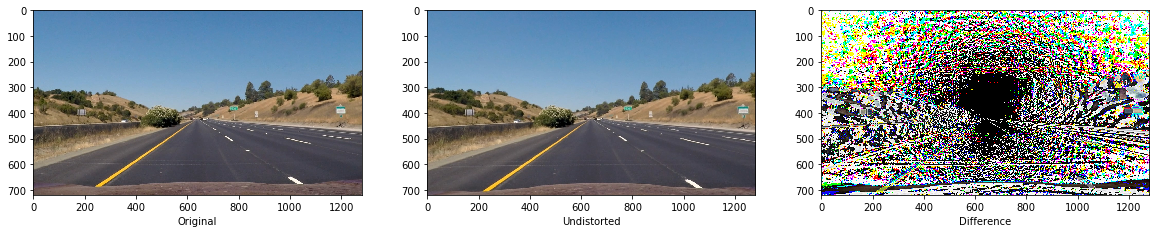

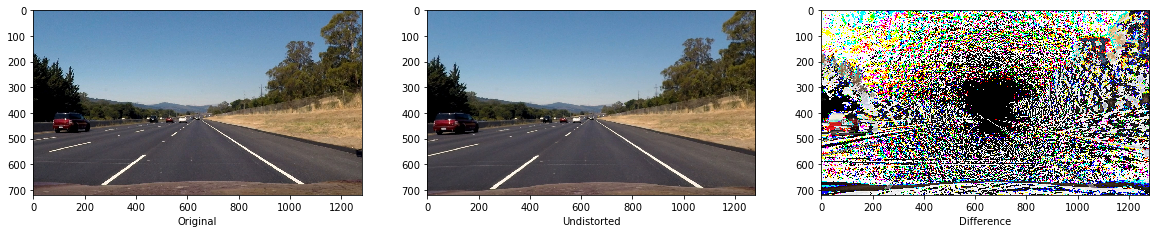

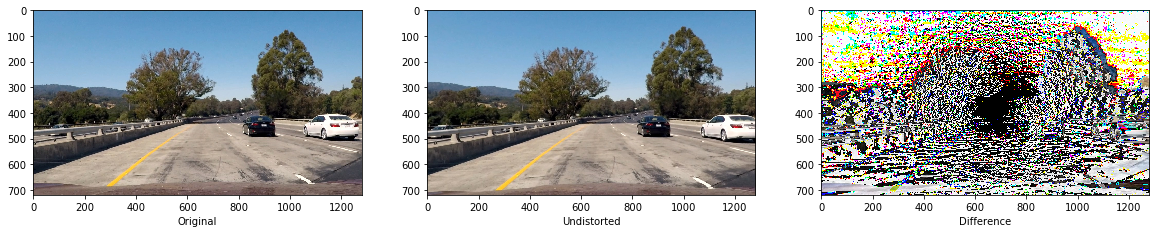

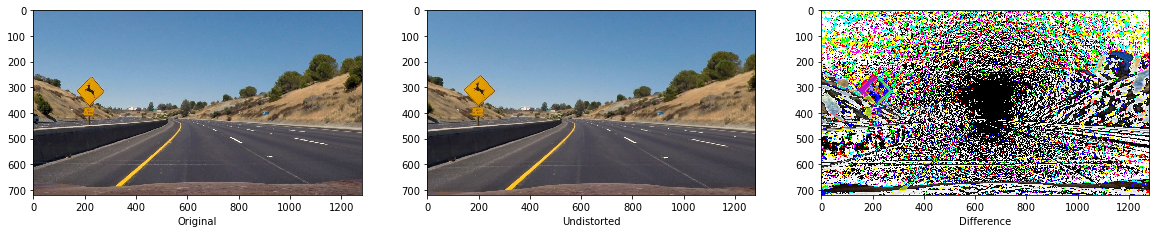

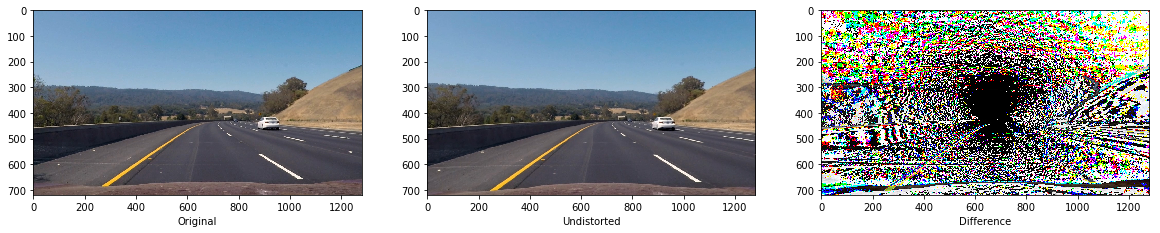

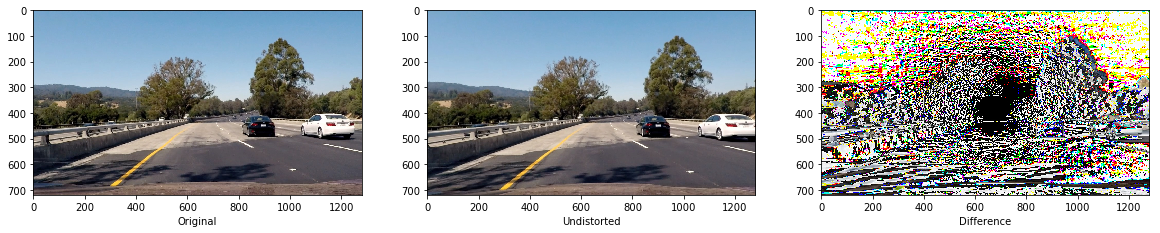

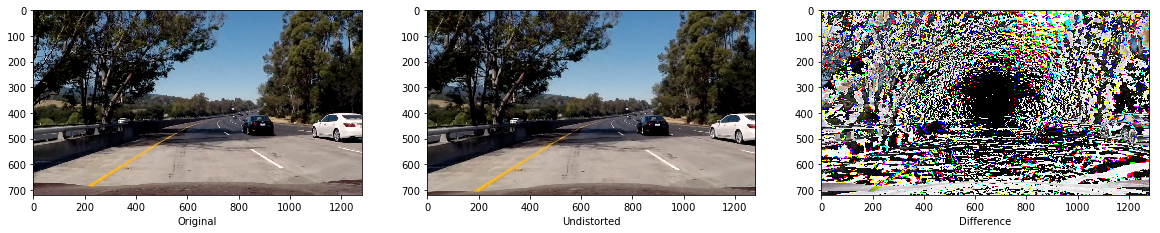

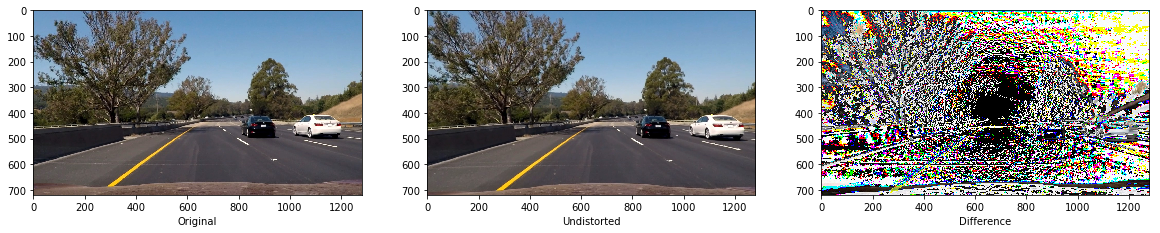

In [12]:
test_path = 'test_images/'
test_file_names = os.listdir(test_path)
test_images = load_images(test_path,test_file_names)
# Undistort all the test images and visualize the difference
for i in range(len(test_images)):
    img = cv2.cvtColor(test_images[i],cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure(i,figsize=(20,10))
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.xlabel('Original')
    plt.subplot(132)
    plt.imshow(dst, cmap = 'gray')
    plt.xlabel('Undistorted')
    plt.subplot(133)
    plt.imshow(img-dst, cmap = 'gray')
    plt.xlabel('Difference')
    test_images[i]=dst


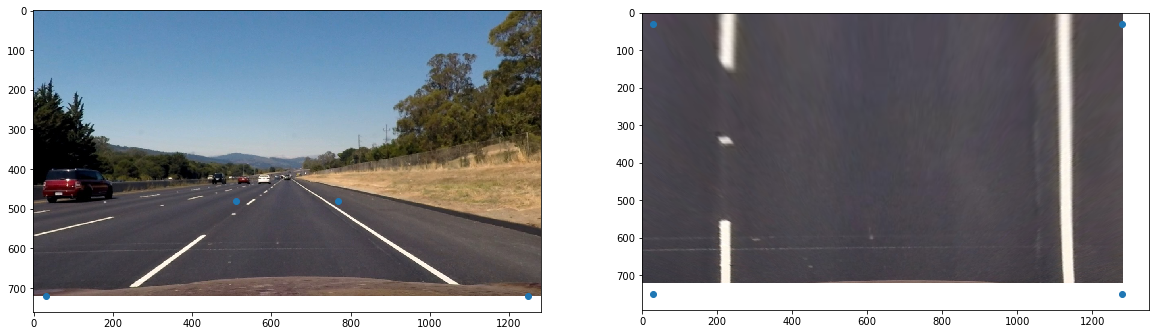

In [71]:
# Create Source and Destination points for 4 point Perspective Transform
img = test_images[1]
img_size = test_images[0].shape
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - 0.95*np.uint(img_size[1]/2)
cbr_window = c_window + 0.95*np.uint(img_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[30,img_size[0]+30],[img_size[1],img_size[0]+30],
                  [img_size[1],30],[30,30]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.scatter(x=src[:,0],y=src[:,1])

plt.subplot(122)
warped = cv2.warpPerspective(img, M,
                          (img.shape[1],img.shape[0]),
                          flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='gray')
plt.scatter(x=dst[:,0],y=dst[:,1])



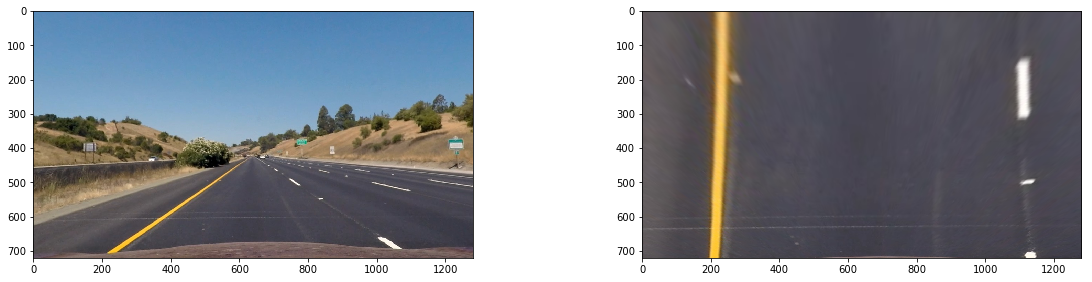

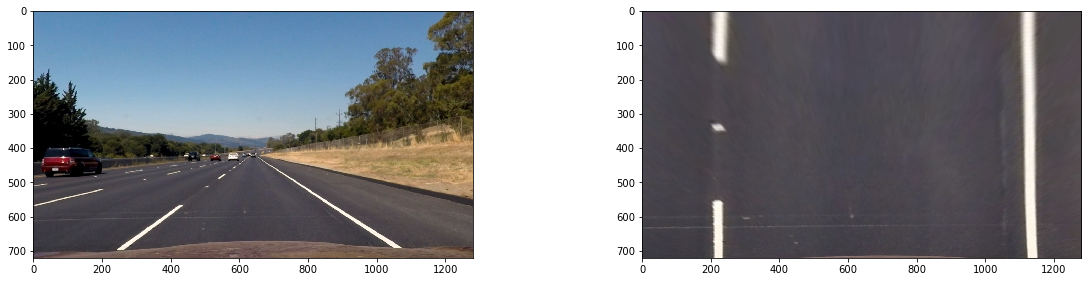

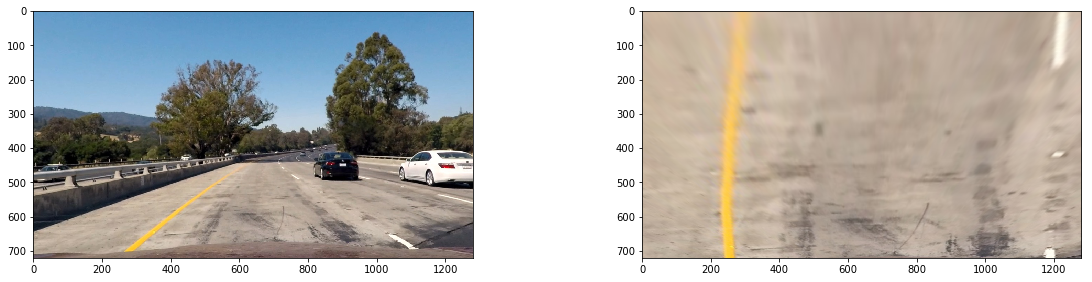

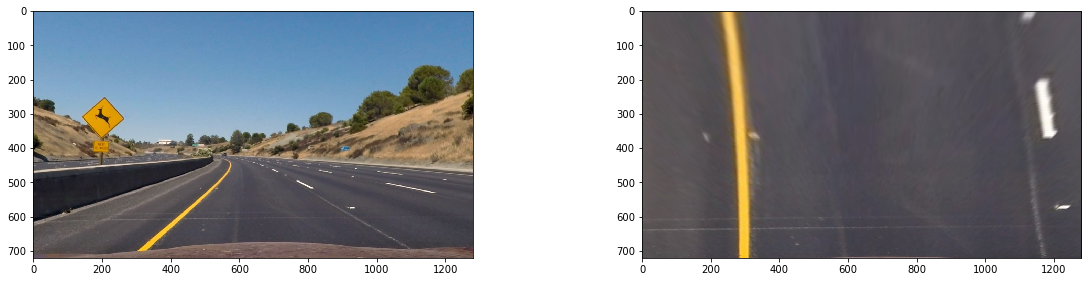

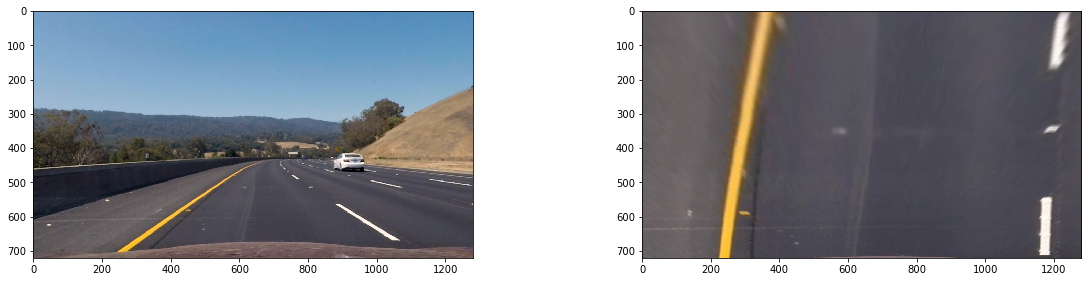

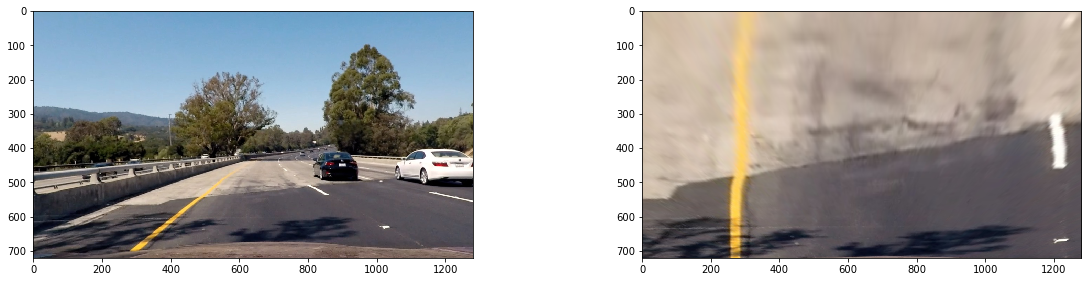

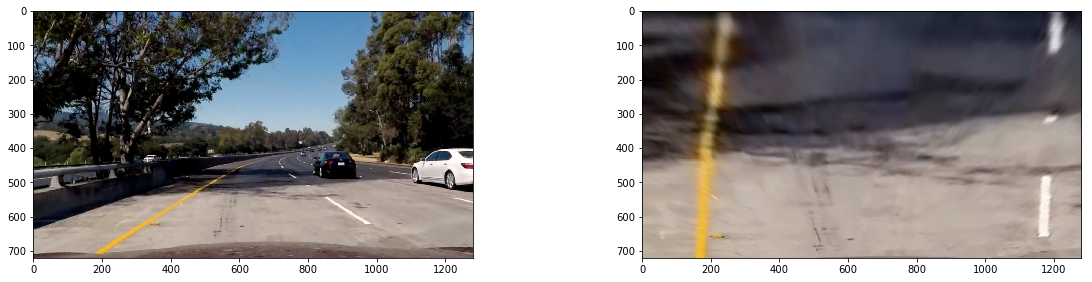

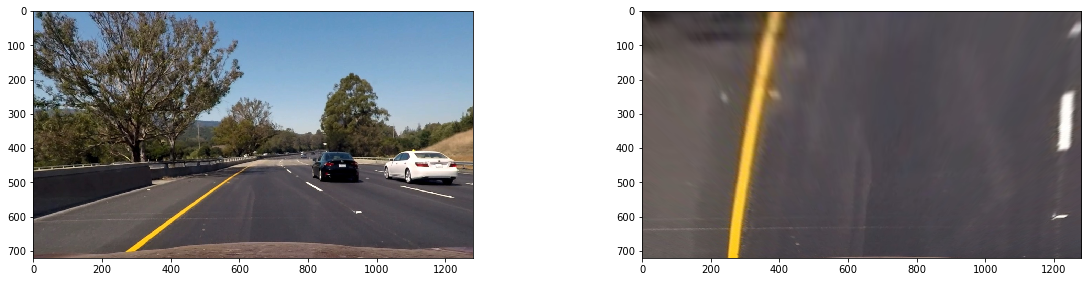

In [72]:


ipm_images = []
for i in range(len(test_images)):
    img = test_images[i]
    
    warped = cv2.warpPerspective(img, M, 
                                        (img.shape[1],img.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.imshow(img,cmap = 'gray')
    plt.subplot(222)
    plt.imshow(warped,cmap='gray')
    ipm_images.append(warped)

In [73]:
def get_sobel_by_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     gray = clahe.apply(gray)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient is 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return binary_output

In [74]:
def get_gradient_magnitude_mask(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255. 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

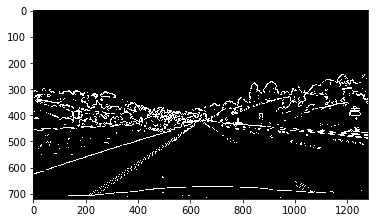

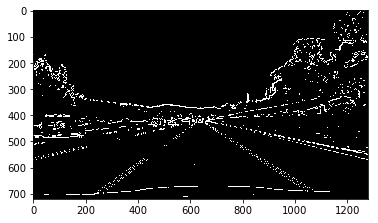

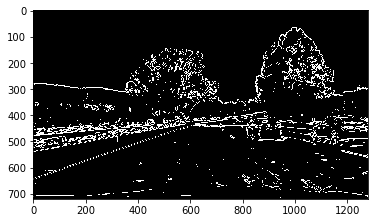

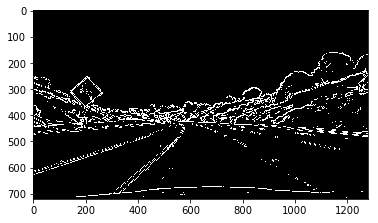

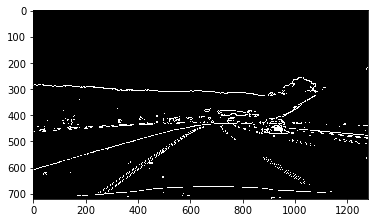

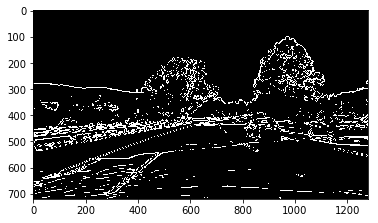

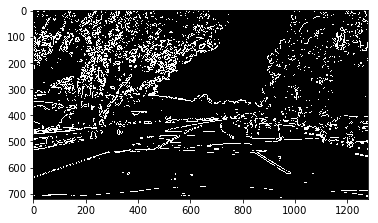

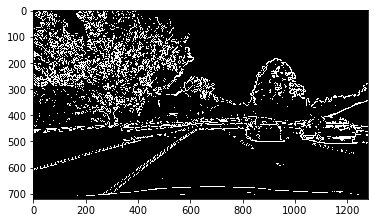

In [75]:
for image in test_images:
    mag_mask = get_gradient_magnitude_mask(image, sobel_kernel=9, mag_thresh = (40,100) )
    plt.imshow(mag_mask, cmap='gray')
    plt.show()

In [76]:
def get_gradient_direction_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

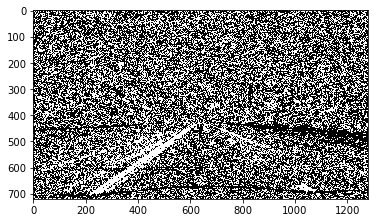

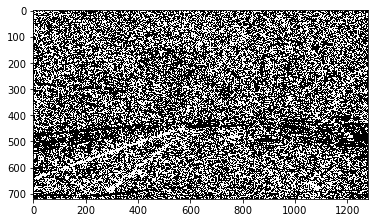

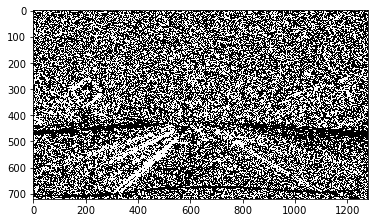

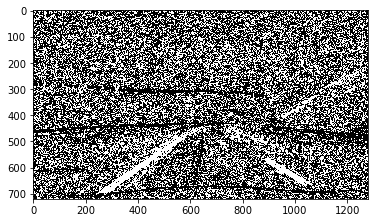

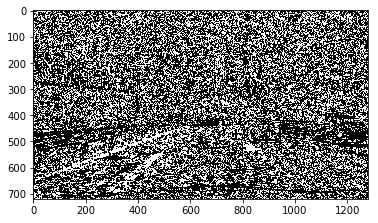

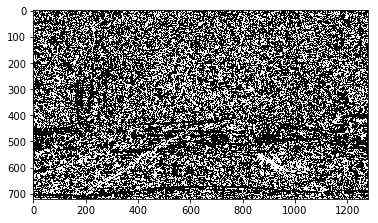

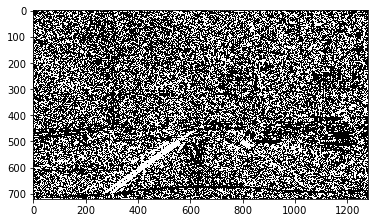

In [77]:
for image in test_images:
    dir_mask = get_gradient_direction_mask(image, sobel_kernel=15, thresh=(0.7,1.3))
    plt.imshow(dir_mask,cmap='gray')
    plt.show()

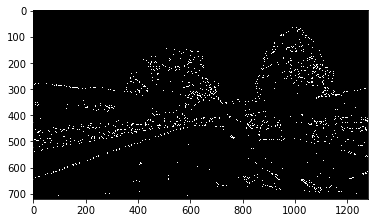

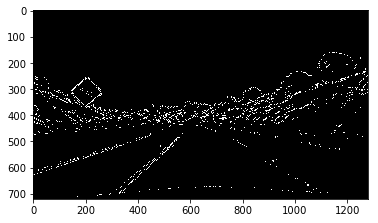

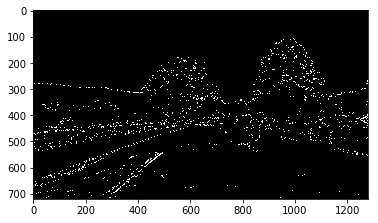

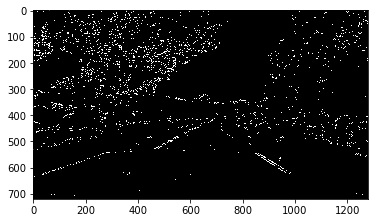

In [78]:
ksize = 3
for image in test_images:
    gradx = get_sobel_by_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = get_sobel_by_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = get_gradient_magnitude_mask(image, sobel_kernel=9, mag_thresh=(40, 100))
    dir_binary = get_gradient_direction_mask(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    plt.imshow(combined,cmap='gray')
    plt.show()

In [79]:
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    # Apply Gaussian adaptive thresholding
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def color_pipeline(img):    
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    yellow_lb= np.array([ 0,  100,  100])
    yellow_ub = np.array([ 50, 255, 255])
    y_mask = cv2.inRange(image_HSV, yellow_lb, yellow_ub)
    yellow_bin = cv2.bitwise_and(img,img, mask= y_mask)
    
    white_lb  = np.array([ 0,   0,   160])
    white_ub = np.array([ 255,  10, 255])
    w_mask = cv2.inRange(image_HSV, white_lb, white_ub)
    white_bin = cv2.bitwise_and(img,img,mask=w_mask)    
    color_mask = cv2.bitwise_or(y_mask,w_mask)
    
    
    return color_mask

In [80]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

def gradient_pipeline(img):
    image_HLS = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    img_gs = image_HLS[:,:,1]
    #img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    sobel_c = sobel_combined(img_gs)
    #img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
    #img_m_mag = mag_thresh(img_gs,5,(20,265))
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    l_channel_sobel = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    #img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    sobel_c = sobel_combined(img_gs)
    #img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
    #img_m_mag = mag_thresh(img_gs,5,(20,265))
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))

    s_channel_sobel = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    combined = cv2.bitwise_or(l_channel_sobel,s_channel_sobel)
    return combined
    

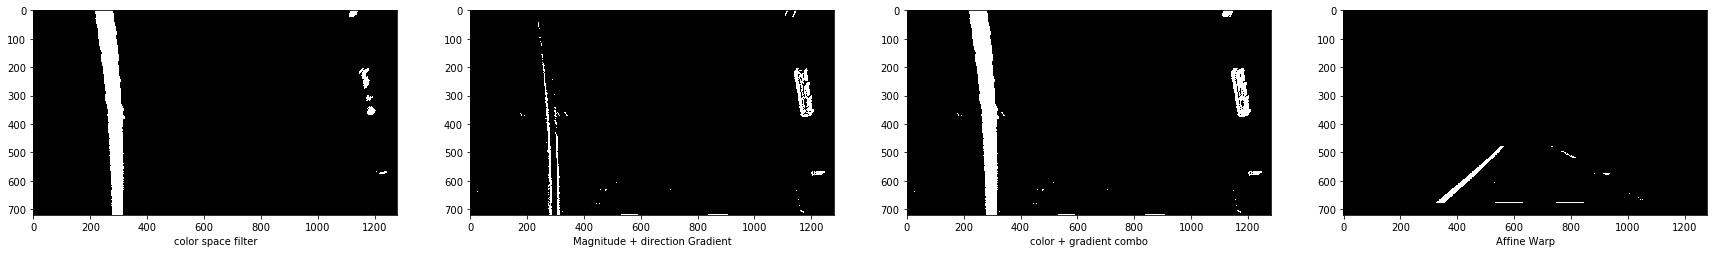

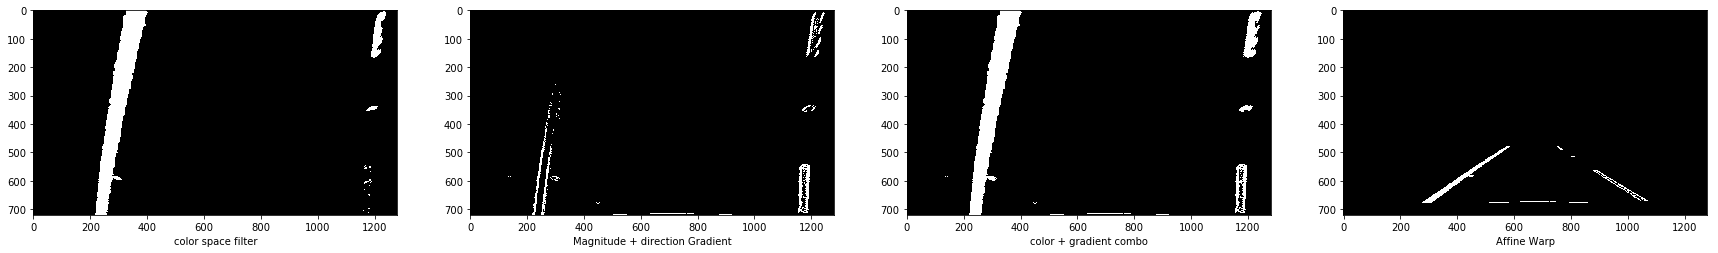

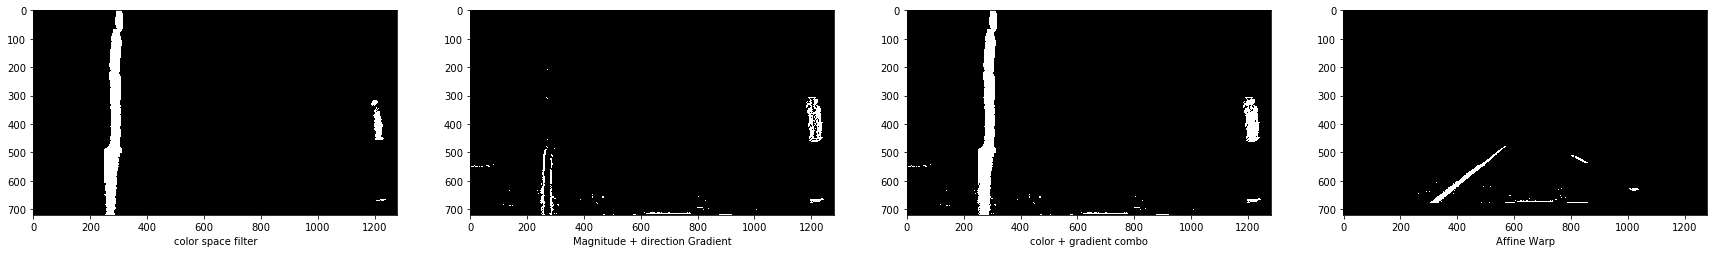

In [81]:
lane_masks = []
for image in ipm_images:
    color_mask = color_pipeline(image)

    grad_mask = gradient_pipeline(image)

    plt.figure(figsize=(30,15))
    plt.subplot(141)
    plt.xlabel('color space filter')
    plt.imshow(color_mask,cmap='gray')
    plt.subplot(142)
    plt.xlabel('Magnitude + direction Gradient')
    plt.imshow(grad_mask,cmap='gray')
    plt.subplot(143)
    
    lane_mask  = np.zeros_like(color_mask)
    lane_mask [ ( color_mask >=0.5 ) | (grad_mask >=0.5)] = 1
    plt.xlabel('color + gradient combo')
    plt.imshow(lane_mask,cmap = 'gray')
    plt.subplot(144)
    plt.xlabel('Affine Warp')
    lane_mask_in_perspective = cv2.warpPerspective(lane_mask, Minv, (image.shape[1], image.shape[0]))
    plt.imshow(lane_mask_in_perspective,cmap = 'gray')
    lane_masks.append(lane_mask)
    
    plt.show()

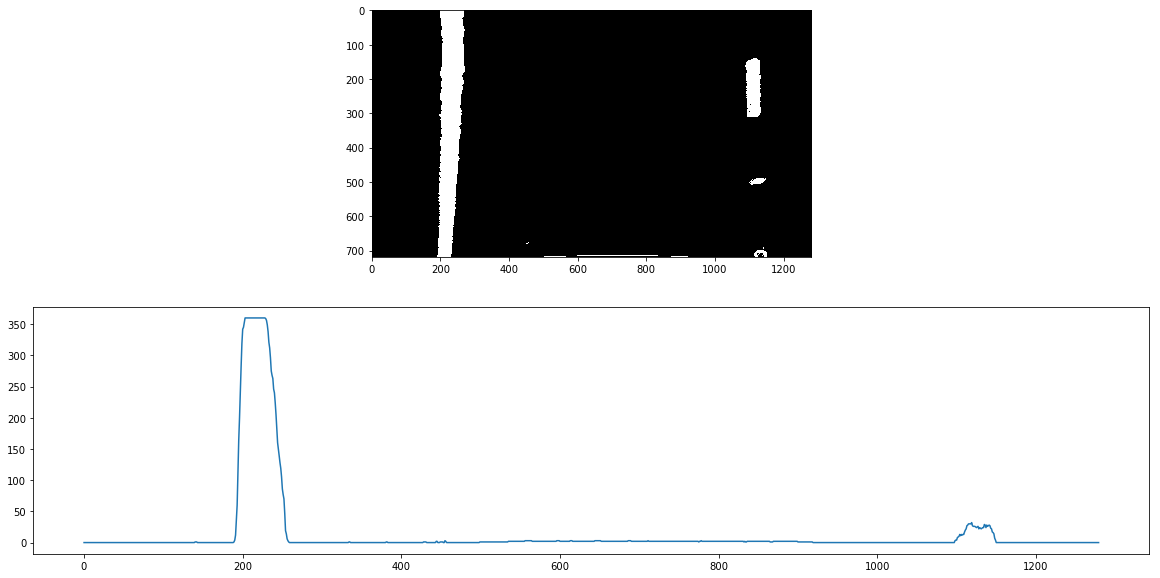

In [82]:
img = lane_masks[np.random.randint(0,len(lane_masks))]
histogram = np.sum(img[np.int32(img.shape[0]/2):,:], axis=0)
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.imshow(img,cmap='gray')
plt.subplot(212)
plt.plot(histogram)

In [83]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [84]:
def lane_finder(binary_warped):

    histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    window_img = np.zeros_like(out_img)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = np.zeros_like(window_img)
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
    
    return result, left_fit, right_fit

In [85]:
def annotate_frame(image):
    image =cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image_warped = cv2.warpPerspective(image, M, 
                                        (img.shape[1],img.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    gradient_mask = gradient_pipeline(image_warped)
    color_mask = color_pipeline(image_warped)
    lane_mask  = np.zeros_like(color_mask)
    lane_mask [ ( color_mask >=0.5 ) | (gradient_mask >=0.5)] = 1
    
    disp_image,left_fit, right_fit = lane_finder(lane_mask)
    
    
    disp_image = cv2.warpPerspective(disp_image, Minv, 
                                        (image.shape[1],image.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(image,1.0, disp_image,0.5,0)

    cv2.imshow('win', result)
    cv2.waitKey(1)
    return cv2.cvtColor(result,cv2.COLOR_RGB2BGR)

In [90]:
lane_output = 'challenge_annotated.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
annotated_clip = clip1.fl_image(annotate_frame)
%time annotated_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video challenge_annotated.mp4
[MoviePy] Writing video challenge_annotated.mp4


100%|██████████| 485/485 [02:58<00:00,  2.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_annotated.mp4 

CPU times: user 7min 9s, sys: 50.4 s, total: 8min
Wall time: 2min 59s


In [91]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1